# Clothes Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of Lab 2 on SVM: Fashion MNIST (https://pravarmahajan.github.io/fashion/), a dataset of small images of clothes and accessories.

The dataset labels are the following:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [1]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  0.23.2


In [2]:
# helper function to load Fashion MNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Place a seed for the random generator (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [3]:
ID = 2021861
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the MNIST dataset: 60000


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [5]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [57 65 56 51 64 59 53 63 70 62]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [57 65 56 51 64 59 53 63 70 62]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


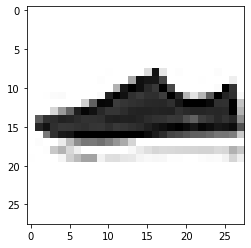

LABEL: 7
INPUT:


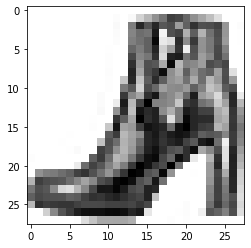

LABEL: 9
INPUT:


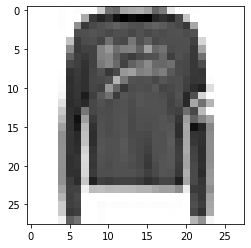

LABEL: 2


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,1000)

### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=250, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [8]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (30,), (20,20,), (30,30,20) ]}

mlp = MLPClassifier(max_iter=250, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

grid_mlp = GridSearchCV(mlp, parameters, cv=5)
grid_mlp.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid_mlp.best_params_)

print("Score with best parameters:")
print(grid_mlp.best_score_)

print("\nAll scores on the grid:")
pd.DataFrame(grid_mlp.cv_results_).loc[:, ['params', 'rank_test_score', 'mean_test_score']]

RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (30,)}
Score with best parameters:
0.7766666666666666

All scores on the grid:


,params,rank_test_score,mean_test_score
0,"{'hidden_layer_sizes': (10,)}",3,0.750000
1,"{'hidden_layer_sizes': (20,)}",2,0.761667
2,"{'hidden_layer_sizes': (30,)}",1,0.776667
3,"{'hidden_layer_sizes': (20, 20)}",4,0.676667
4,"{'hidden_layer_sizes': (30, 30, 20)}",5,0.366667


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [9]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!
parameters = {'batch_size': [1, 32, 480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits=5)

best_mlp = grid_mlp.best_estimator_

# recall to use cv=kf to use the k-fold subdivision seen in the lectures

grid_train_mlp = GridSearchCV(best_mlp, parameters)
grid_train_mlp.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid_train_mlp.best_params_)

print("Score with best parameters:")
print(grid_train_mlp.best_score_)

print("\nAll scores on the grid:")
pd.DataFrame(grid_train_mlp.cv_results_).loc[:,['params', 'rank_test_score', 'mean_test_score']]

RESULTS FOR NN

Best parameters set found:
{'batch_size': 32}
Score with best parameters:
0.7749999999999999

All scores on the grid:


,params,rank_test_score,mean_test_score
0,{'batch_size': 1},3,0.098333
1,{'batch_size': 32},1,0.775000
2,{'batch_size': 480},2,0.771667


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?

In general, we observe that increasing the number of layers leads to worse performances. The point is that we're neglecting the regularization term during the training, and hence making the architecture more complex means overfitting the data. Regarding the number of neurons for each layer, in that case adding neurons leads to better performances. Nevertheless, the behaviour is not obvious to understand since for another seed I found that, in the case of just one layer, the more complex model had the best score, but the simplest one ranked second. For what concearn the batch size (bs) for the training, in general we expect that by increasing the bs we get a more stable solution. In that case we find that bs=1 leads to a totally ineffective training, while for bs=32 we get already the best possible result, except for fluctuations that can always occur. Therefore there is no point in using bs=480, which also takes more time for the NN to be trained.

### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 300 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

Training MLP of size (10,) ...
Done, training time: 0.83 sec

Training MLP of size (20,) ...
Done, training time: 0.74 sec

Training MLP of size (30,) ...
Done, training time: 0.88 sec

Training MLP of size (30, 20) ...
Done, training time: 0.79 sec

Training MLP of size (30, 30, 20) ...
Done, training time: 0.36 sec



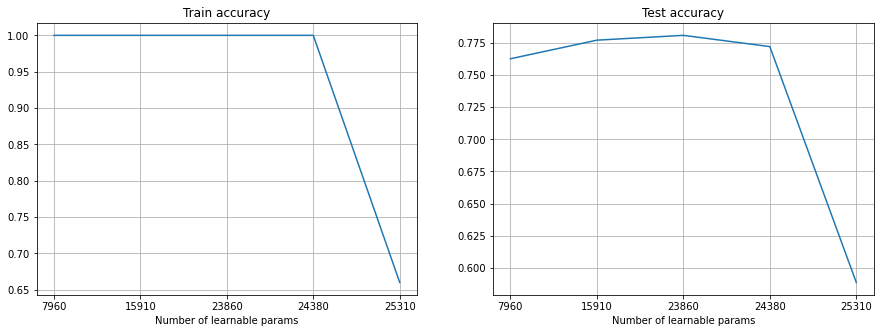

In [10]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(10,), (20,), (30,), (30,20,), (30,30,20)]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(hidden_layer_sizes=hl_size, max_iter=600, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)
    
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

We observe that already for the simplest model the train accuracy saturates at 1, and thus the model overfits the training set. The test set, instead, reaches the best score at a compromise between a too simple model and a too complex one, which corresponds to the configuration (30,). Quite unexpectedly, the training error drops down for the most complex model, even if the training procedure has converged. This should not happen, because we know that the more learnable parameters we have, the more the accuracy over the test set should approach 1. I don't have an explaination for this behaviour, since I tried with different seeds and I got always the same result.

### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 600 iterations. 

/home/lorenzo/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


RESULTS FOR NN

Best parameters set found:
0.001
Score with best parameters:
0.781


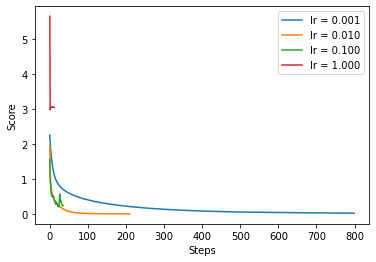

In [11]:
import matplotlib.pyplot as plt
import operator
from sklearn.model_selection import learning_curve

lr_list = [10**exp for exp in range(-3,1)]
scores = np.array([])
mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=800, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, batch_size=32)
for lr in lr_list:
    mlp.set_params(learning_rate_init=lr)
    mlp.fit(X_train, y_train)
    scores = np.append(scores, mlp.score(X_test, y_test))
    plt.plot(mlp.loss_curve_, label='lr = {:.3f}'.format(lr))
plt.xlabel('Steps')
plt.ylabel('Score')
plt.legend(loc='best')
best_index = np.argmax(scores)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(lr_list[best_index])

print("Score with best parameters:")
print(scores[best_index])


### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

By increasing the learning rate the convergence is faster, but also more unstable (as we can see from the "spikes" of the green curve). A learning rate of 0.001 in this case is not sufficient to get convergence within 800 iterations. I also tried with a learning rate of 1, which is way too large and leads to a very poor result. The best compromise is found for lr=0.01

### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case.


RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.220000


Text(0, 0.5, 'Score')

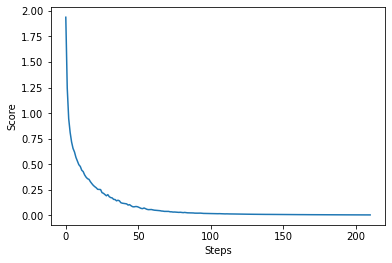

In [12]:
#get training and test error for the best NN model from CV

mlp_600 = MLPClassifier(hidden_layer_sizes=(30,), max_iter=800, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, batch_size=32, learning_rate_init=0.01)
mlp_600.fit(X_train, y_train)
training_error = 1 - mlp_600.score(X_train, y_train)
test_error = 1 - mlp_600.score(X_test, y_test)

print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

plt.plot(mlp_600.loss_curve_)
plt.xlabel('Steps')
plt.ylabel('Score')

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [13]:
X = X[permutation]
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [408 426 392 415 400 382 409 390 385 393]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [14]:
# use best architecture and params from before

mlp_4000 = MLPClassifier(hidden_layer_sizes=(30,), max_iter=600, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, batch_size=32, learning_rate_init=0.01, verbose=False)
mlp_4000.fit(X_train, y_train)

print ('\nRESULTS FOR NN\n')

#get training and test error for the NN

training_error = 1 - mlp_4000.score(X_train, y_train)
test_error = 1 - mlp_4000.score(X_test, y_test)

print ("NN training error: %f" % training_error)
print ("NN test error: %f" % test_error)



RESULTS FOR NN

NN training error: 0.000000
NN test error: 0.176125


## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

In both cases we find that the training error is "zero" (i.e. negligible) and in the case of the larger training set we find a test error which is smaller than before. This improvement is due to a larger training set, which makes the model more robust.

### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

INPUT:


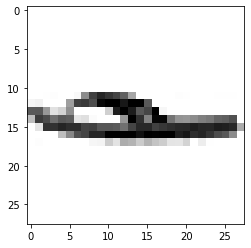

LABEL: 5


In [15]:
NN_prediction = mlp_600.predict(X_train)
large_NN_prediction = mlp_4000.predict(X_train)

correct_4000 = large_NN_prediction == y_train
wrong_600 = NN_prediction == y_train
index = 0
for i, obj in enumerate(correct_4000):
    if obj == wrong_600[i]:
        indez = i
        break
plot_input(X_train, y_train, index)    

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


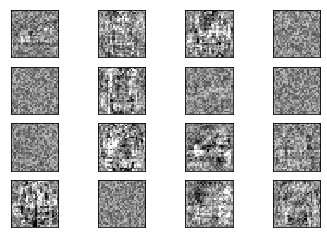

Weights with 4000 data points:


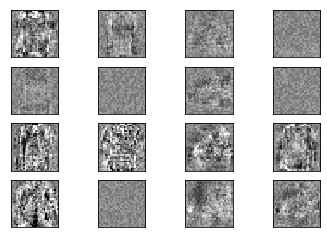

In [16]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_600.coefs_[0].min(), mlp_600.coefs_[0].max()
for coef, ax in zip(mlp_600.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_4000.coefs_[0].min(), mlp_4000.coefs_[0].max()
for coef, ax in zip(mlp_4000.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 5

Describe what do you observe by looking at the weights.

The image of the NN trained with 4000 samples in some cases has more defined edges wiht respect to the one with 600 samples. Sometimes it is also possible to recognize, a shape that reminds the clothes profile

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [17]:
m_training = 4000

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# use best parameters found in the SVM notebook, create SVM and perform fitting

svm = SVC(C=5, gamma=0.005, kernel='rbf')
svm.fit(X_train, y_train)

print ('RESULTS FOR SVM')

SVM_training_error =  1 - svm.score(X_train, y_train)

print("Training score SVM:")
print(SVM_training_error)

SVM_test_error = 1 - svm.score(X_test, y_test)
print("Test score SVM:")
print(SVM_test_error)

RESULTS FOR SVM
Training score SVM:
0.06474999999999997
Test score SVM:
0.15100000000000002


In [18]:
from sklearn import linear_model

regL2 = linear_model.LogisticRegression(C=1, max_iter=1000)

# you can re-use your code from Lab 2

regL2.fit(X_train, y_train)

print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')

training_error =  1 - regL2.score(X_train, y_train)
test_error =  1 - regL2.score(X_test, y_test)

print ("Training error (reg): %f" % training_error)
print ("Test error (reg): %f" % test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
Training error (reg): 0.039750
Test error (reg): 0.185250


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

In order of performances we have: 1) SVM, 2) NN, 3) logistic regression. In terms of time required for the training we have (ascending order): 1) logistic regression, 2) SVM, 3) NN. In that case the best compromise is therefore given by the SVM model. In order to get better performances we have to look for deep network, such as CNN.